In [1]:
import os
import sys
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use("ggplot")

## Exercise 2.11

In [2]:
class BanditEnv(object):
    def __init__(self,qs):
        self.qs = qs.copy()
        self.reset()
    
    def reset(self):
        self.means = self.qs.copy()
        self.stds = [1 for i in self.qs]
        self.action_space = len(self.qs)
    
    def step(self,action):
        std,mean = self.stds[action],self.means[action]
        rand_raward = np.random.normal(mean,std)
        return rand_raward

In [3]:
class NonstationaryBanditEnv(BanditEnv):
    def step(self,action):
        std,mean = self.stds[action],self.means[action]
        rand_raward = np.random.normal(mean,std)
        for one_action in range(self.action_space):
            self.means[one_action] += np.random.normal(0,0.01)
        return rand_raward

In [4]:
from abc import ABCMeta, abstractmethod, abstractproperty
import math
class Solver(metaclass=ABCMeta):
    def __init__(self,env):
        self.env = env
        self.action_space = env.action_space
        
    @abstractmethod
    def back(self,selected_action,reward):
        pass
    
    @abstractmethod
    def select_action(self):
        pass
    
    def solve(self,steps):
        self.Qs = [np.inf for i in range(self.action_space)]
        self.action_steps = [0 for i in range(self.action_space)]
        
        rewards = []
        actions = []
        correct = []
        for i in range(steps):
            selected_action = self.select_action()
            
            reward = self.env.step(selected_action)
            rewards.append(reward)
            #actions.append(selected_action)
            correct.append(selected_action == np.argmax(self.env.means))
            self.back(selected_action,reward)
            
        return rewards,self.Qs,correct

class SampleAverageSolver(Solver):
    def __init__(self,env,e=0.1):
        super().__init__(env)
        self.e = e
    
    def select_action(self):
        rand_action = np.random.randint(0,self.action_space)
        # explore
        if random.random() < self.e:
            selected_action = rand_action
        # exploit
        else:
            selected_action = np.argmax(self.Qs)  
        return selected_action
    
    def back(self,selected_action,reward):
        self.action_steps[selected_action] += 1
        if self.Qs[selected_action] == np.inf:
            self.Qs[selected_action] = 0
        self.Qs[selected_action] += \
            (1.0 / self.action_steps[selected_action]) * (reward - self.Qs[selected_action])
    
class ConstStepsizeSolver(SampleAverageSolver):
    def back(self,selected_action,reward):
        self.action_steps[selected_action] += 1
        if self.Qs[selected_action] == np.inf:
            self.Qs[selected_action] = 0
        self.Qs[selected_action] += \
            0.1 * (reward - self.Qs[selected_action])
        

In [367]:
class UcbSolver(Solver):
    def __init__(self,env,c=0.1):
        super().__init__(env)
        self.c = c
        self.times = 0
    
    def select_action(self):
        A_values = [
            (
                self.Qs[i] 
                + self.c 
                * np.sqrt(
                            (math.log(self.times + 1))
                          / (self.action_steps[i] + 1e-5)
                         )
            )
            for i in range(self.action_space)]
        selected_action = np.argmax(A_values)
        return selected_action
    
    def back(self,selected_action,reward):
        self.action_steps[selected_action] += 1
        self.times += 1

        if self.Qs[selected_action] == np.inf:
            self.Qs[selected_action] = 0
        self.Qs[selected_action] += \
            0.1 * (reward - self.Qs[selected_action])
        
def softmax(x):
    totalSum = np.sum(np.exp(x), axis = 0)
    return np.exp(x)/totalSum

mm = 0
class GrandientBanditSolver(Solver):
    def __init__(self,env,a=0.1):
        super().__init__(env)
        self.a = a
        self.times = 0
    
    def select_action(self):
        global mm
        probs = softmax(self.H)
        #print(probs)
        #mm += 1
        #if mm >= 5:
        #    bb
        selected_action = random.choices(self.actions_ind,weights=probs)[0]
        #print("selected action",selected_action)
        return selected_action
    
    def back(self,selected_action,reward):
        self.action_steps[selected_action] += 1
        self.times += 1

        if self.Qs[selected_action] == np.inf:
            self.Qs[selected_action] = 0
        self.Qs[selected_action] += \
            0.1 * (reward - self.Qs[selected_action])
        
        for one_action in range(self.action_space):
            strategy = softmax(self.H)
            avg_reward = (strategy * self.Qs).sum()
            if one_action == selected_action:
                self.H[one_action] += self.a * (reward - avg_reward) * (1 - strategy[one_action])
            else:
                self.H[one_action] -= self.a * (reward - avg_reward) * (strategy[one_action])
                
    def solve(self,steps):
        self.Qs = np.asarray([0 for i in range(self.action_space)],np.float)
        self.action_steps = np.asarray([0 for i in range(self.action_space)])
        self.H = np.asarray([0 for i in range(self.action_space)],np.float)
        self.actions_ind = np.asarray(list(range(self.action_space)))
        
        rewards = []
        actions = []
        correct = []
        for i in range(steps):
            selected_action = self.select_action()
            
            reward = self.env.step(selected_action)
            rewards.append(reward)
            #actions.append(selected_action)
            correct.append(selected_action == np.argmax(self.env.means))
            self.back(selected_action,reward)
            
        return rewards,self.Qs,correct
    
class ConstantStepGrandientBanditSolver(GrandientBanditSolver):
    def back(self,selected_action,reward):
        self.action_steps[selected_action] += 1
        self.times += 1

        if self.Qs[selected_action] == np.inf:
            self.Qs[selected_action] = 0
        self.Qs[selected_action] += \
            0.1 * (reward - self.Qs[selected_action])
        
        for one_action in range(self.action_space):
            strategy = softmax(self.H)
            avg_reward = (strategy * self.Qs).sum()
            if one_action == selected_action:
                self.H[one_action] = self.H[one_action] * 0.99 + self.a * (reward - avg_reward) * (1 - strategy[one_action])
            else:
                self.H[one_action] = self.H[one_action] * 0.99 - self.a * (reward - avg_reward) * (strategy[one_action])
                

In [368]:
env = NonstationaryBanditEnv(np.zeros(10))

In [369]:
def graph_runner(solver,run_times,solve_steps):
    
    sums = np.zeros(solve_steps)
    corrects = np.zeros(solve_steps)
    
    for i in range(run_times):
        solver.env.reset()
        rewards,Qs,correct_action = solver.solve(solve_steps)
        rewards = np.asarray(rewards)
        correct_action = np.asarray(correct_action)
        
        sums += rewards
        corrects += np.asarray(correct_action,np.float)
    avg_reward = sums / run_times
    optimal_action = corrects / run_times
    
    return avg_reward,optimal_action

In [371]:
sample_average_solver = SampleAverageSolver(NonstationaryBanditEnv(np.zeros(10)))
const_stepsize_solver = ConstStepsizeSolver(NonstationaryBanditEnv(np.zeros(10)))
ucb_solver = UcbSolver(NonstationaryBanditEnv(np.zeros(10)),c=2)
grandient_bandit_solver = GrandientBanditSolver(NonstationaryBanditEnv(np.zeros(10)),a=0.1)
constant_step_grandient_bandit_solver = ConstantStepGrandientBanditSolver(NonstationaryBanditEnv(np.zeros(10)),a=0.1)
grandient_bandit_solver_static = GrandientBanditSolver(BanditEnv(np.random.randn(10)),a=0.1)

In [9]:
avg_reward_dic = {}
optimal_action_dic = {}
run_times = 100
solve_steps = 10000

In [10]:
random.seed(1230)
np.random.seed(1230)
avg_reward,optimal_action = graph_runner(sample_average_solver,run_times,solve_steps)
avg_reward_dic["sample_average"] = avg_reward
optimal_action_dic["sample_average"] = optimal_action

In [11]:
random.seed(1230)
np.random.seed(1230)
avg_reward,optimal_action = graph_runner(const_stepsize_solver,run_times,solve_steps)
avg_reward_dic["const_stepsize"] = avg_reward
optimal_action_dic["const_stepsize"] = optimal_action

In [12]:
random.seed(1230)
np.random.seed(1230)
avg_reward,optimal_action = graph_runner(ucb_solver,run_times,solve_steps)
avg_reward_dic["ucb_solver"] = avg_reward
optimal_action_dic["ucb_solver"] = optimal_action

In [352]:
random.seed(1230)
np.random.seed(1230)
avg_reward,optimal_action = graph_runner(grandient_bandit_solver,run_times,solve_steps)
avg_reward_dic["grandient_bandit_solver"] = avg_reward
optimal_action_dic["grandient_bandit_solver"] = optimal_action

In [353]:
random.seed(1230)
np.random.seed(1230)
avg_reward,optimal_action = graph_runner(grandient_bandit_solver_static,run_times,solve_steps)
avg_reward_dic["grandient_bandit_solver_static"] = avg_reward
optimal_action_dic["grandient_bandit_solver_static"] = optimal_action

In [372]:
random.seed(1230)
np.random.seed(1230)
avg_reward,optimal_action = graph_runner(constant_step_grandient_bandit_solver,run_times,solve_steps)
avg_reward_dic["constant_step_grandient_bandit_solver"] = avg_reward
optimal_action_dic["constant_step_grandient_bandit_solver"] = optimal_action

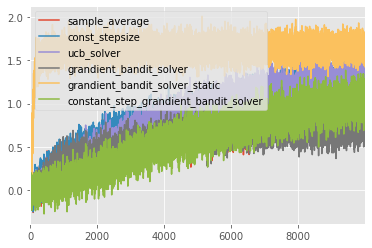

In [373]:
pd.DataFrame(avg_reward_dic).plot()

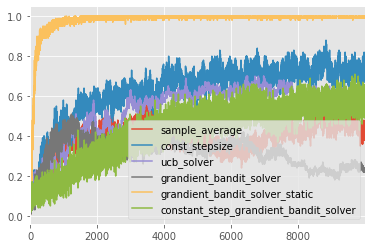

In [374]:
pd.DataFrame(optimal_action_dic).plot()